# vLife Virtusa
## Medication Recommendation Using Patient Reviews
### Usecase Description
<p> Light GBM classifier is used along with keras to calculate the sentiment scores of medicines and then recommend it to the patients based upon certain input components like the review submitted by the patient, the current medication he/she is taking, his/her rating against the medication and the condition.</p>

### Dataset Source
Data for this usecase can be found [here](https://archive.ics.uci.edu/ml/datasets/Drug+Review+Dataset+%28Drugs.com%29).

### Dataset Description
<p> The dataset provides patient reviews on specific drugs along with related conditions and a 10 star patient rating reflecting overall patient satisfaction. The data was obtained by crawling online pharmaceutical review sites. The intention was to study</p>.

1. sentiment analysis of drug experience over multiple facets, i.e. sentiments learned on specific aspects such as effectiveness and side effects,
2. the transferability of models among domains, i.e. conditions, and
3. the transferability of models among different data sources (see 'Drug Review Dataset (Druglib.com)').

The data is split into a train (75%) a test (25%) partition (see publication) and stored in two .tsv (tab-separated-values) files, respectively.

> **Necessary Imports**

In [7]:
import re
import gc
import os
import string
import nltk
color = sns.color_palette()
import pandas as pd #Analysis 
import matplotlib.pyplot as plt #Visulization
import seaborn as sns #Visulization
import numpy as np #Analysis 
from scipy.stats import norm #Analysis 
from sklearn.preprocessing import StandardScaler #Analysis 
from scipy import stats #Analysis 
import warnings 
import keras
from keras.models import Sequential
from keras.layers import Dense
import random
warnings.filterwarnings('ignore')
%matplotlib inline

from plotly import tools
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go

from sklearn import model_selection, preprocessing, metrics, ensemble, naive_bayes, linear_model
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import TruncatedSVD
import lightgbm as lgb

from bs4 import BeautifulSoup
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer

from sklearn import model_selection, preprocessing, metrics, ensemble, naive_bayes, linear_model
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import TruncatedSVD
import lightgbm as lgb

from bs4 import BeautifulSoup
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.pipeline import Pipeline

from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.pipeline import Pipeline

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation, CuDNNGRU, Conv1D
from keras.layers import Bidirectional, GlobalMaxPool1D
from keras.models import Model
from keras import initializers, regularizers, constraints, optimizers, layers

from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense, Bidirectional, LSTM, BatchNormalization, Dropout
from tensorflow.python.keras.preprocessing.sequence import pad_sequences

pd.options.mode.chained_assignment = None
pd.options.display.max_columns = 999

## 1. Exploration Data Analysis

### 1.1. Data understanding
First we will import Train data and Test data. The sizes of the two data are as follows:

In [9]:
df_train = pd.read_csv("drugsComTrain_raw.csv", parse_dates=["date"])
df_test = pd.read_csv("drugsComTest_raw.csv", parse_dates=["date"])

In [11]:
print("Train shape :" ,df_train.shape)
print("Test shape :", df_test.shape)

Train shape : (161297, 7)
Test shape : (53766, 7)


This is the result of looking at the data through the head () command. There are six variables except for the unique ID that identifies the individual, and review is the key variable.

In [12]:
df_train.head()

,uniqueID,drugName,condition,review,rating,date,usefulCount
0,206461,Valsartan,Left Ventricular Dysfunction,"""It has no side effect, I take it in combinati...",9,2012-05-20,27
1,95260,Guanfacine,ADHD,"""My son is halfway through his fourth week of ...",8,2010-04-27,192
2,92703,Lybrel,Birth Control,"""I used to take another oral contraceptive, wh...",5,2009-12-14,17
3,138000,Ortho Evra,Birth Control,"""This is my first time using any form of birth...",8,2015-11-03,10
4,35696,Buprenorphine / naloxone,Opiate Dependence,"""Suboxone has completely turned my life around...",9,2016-11-27,37


These are additional explanations for variables.

- drugName (categorical): name of drug 
- condition (categorical): name of condition
- review (text): patient review 
- rating (numerical): 10 star patient rating 
- date (date): date of review entry 
- usefulCount (numerical): number of users who found review useful

The structure of the data is that a patient with a unique ID purchases a drug that meets his condition and writes a review and rating for the drug he/she purchased on the date. Afterwards, if the others read that review and find it helpful, they will click usefulCount, which will add 1 for the variable.

### 1.2. Data understanding

First, we will start exploring variables, starting from uniqueID. We compared the unique number of unique IDs and the length of the train data to see if the same customer has written multiple reviews, and there weren't more than one reviews for one customer.

In [13]:
print("unique values count of train : " ,len(set(df_train['uniqueID'].values)))
print("length of train : " ,df_train.shape[0])

unique values count of train :  161297
length of train :  161297


DrugName is closely related to condition, so we have analyzed them together. The unique values of the two variables are 3671 and 917, respectively, and there are about 4 drugs for each condition. Let's go ahead and visualize this in more detail.

In [14]:
df_all = pd.concat([df_train,df_test])
df_all.head()

,uniqueID,drugName,condition,review,rating,date,usefulCount
0,206461,Valsartan,Left Ventricular Dysfunction,"""It has no side effect, I take it in combinati...",9,2012-05-20,27
1,95260,Guanfacine,ADHD,"""My son is halfway through his fourth week of ...",8,2010-04-27,192
2,92703,Lybrel,Birth Control,"""I used to take another oral contraceptive, wh...",5,2009-12-14,17
3,138000,Ortho Evra,Birth Control,"""This is my first time using any form of birth...",8,2015-11-03,10
4,35696,Buprenorphine / naloxone,Opiate Dependence,"""Suboxone has completely turned my life around...",9,2016-11-27,37


Text(0.5, 1.0, 'Top20 : The number of drugs per condition.')

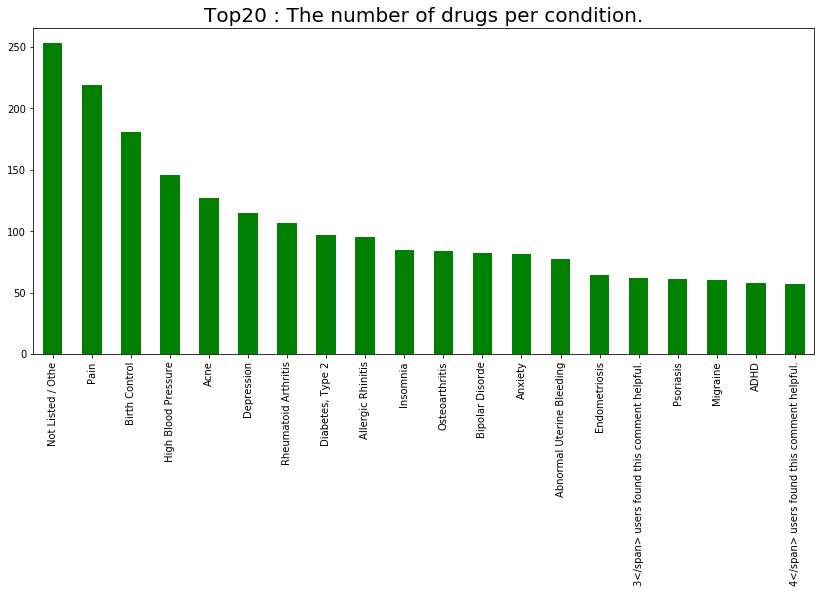

In [15]:
condition_dn = df_all.groupby(['condition'])['drugName'].nunique().sort_values(ascending=False)
condition_dn[0:20].plot(kind="bar", figsize = (14,6), fontsize = 10,color="green")
plt.xlabel("", fontsize = 20)
plt.ylabel("", fontsize = 20)
plt.title("Top20 : The number of drugs per condition.", fontsize = 20)

As you can see from the picture above, the number of drugs for top eight conditions is about 100 for each condition. On the other hand, it should be noted that the phrase "3</span> users found this comment helpful" appears in the condition, which seems like an error in the crawling process. I have looked into it to see in more details.

In [16]:
df_all[df_all['condition']=='3</span> users found this comment helpful.'].head(3)

,uniqueID,drugName,condition,review,rating,date,usefulCount
243,81588,Yaz,3</span> users found this comment helpful.,"""I took Yaz for a little over 2 years. From a...",3,2010-06-01,3
1864,124318,Skyla,3</span> users found this comment helpful.,"""Never pregnant,28,retroverted small (6cm) ute...",1,2015-12-16,3
3322,202848,ProAir HFA,3</span> users found this comment helpful.,"""I get chest colds and asthmatic symptoms in t...",9,2015-12-12,3


It is expected that for structure of '</ span> users found this comment helpful.' phrase, there will be not only 3, but also 4 as shown above, and other numbers as well. We will remove these data in the future preprocessing.

The following are the low 20 conditions of 'drugs per condition'. As you can see, the number is all 1. Considering the recommendation system, it is not feasible to recommend with that when there is only one product. Therefore, we will analyze only the conditions that have at least 2 drugs per condition.

Text(0.5, 1.0, 'Bottom20 : The number of drugs per condition.')

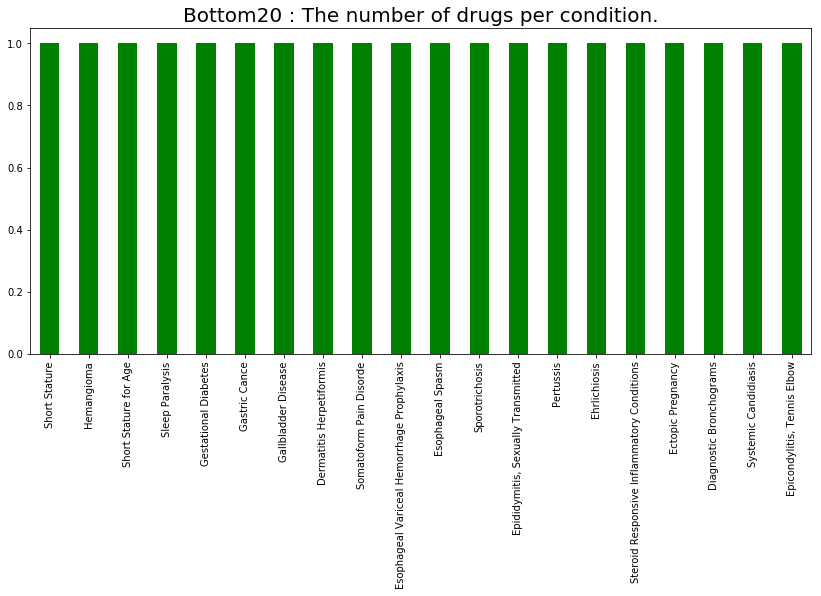

In [17]:
condition_dn = df_all.groupby(['condition'])['drugName'].nunique().sort_values(ascending=False)

condition_dn[condition_dn.shape[0]-20:condition_dn.shape[0]].plot(kind="bar", figsize = (14,6), fontsize = 10,color="green")
plt.xlabel("", fontsize = 20)
plt.ylabel("", fontsize = 20)
plt.title("Bottom20 : The number of drugs per condition.", fontsize = 20)

Next, let's have a look at the review. First, noticeable parts are the html strings like \ r \ n, and the parts that express emotions in parentheses such as (very unusual for him) and (a good thing) and words in capital letters like MUCH.

In [18]:
df_train['review'][1]

'"My son is halfway through his fourth week of Intuniv. We became concerned when he began this last week, when he started taking the highest dose he will be on. For two days, he could hardly get out of bed, was very cranky, and slept for nearly 8 hours on a drive home from school vacation (very unusual for him.) I called his doctor on Monday morning and she said to stick it out a few days. See how he did at school, and with getting up in the morning. The last two days have been problem free. He is MUCH more agreeable than ever. He is less emotional (a good thing), less cranky. He is remembering all the things he should. Overall his behavior is better. \r\nWe have tried many different medications and so far this is the most effective."'

In addition, there were some words with errors like didn&# 039;t for didn't, and also characters like ...

In [19]:
df_train['review'][2]

'"I used to take another oral contraceptive, which had 21 pill cycle, and was very happy- very light periods, max 5 days, no other side effects. But it contained hormone gestodene, which is not available in US, so I switched to Lybrel, because the ingredients are similar. When my other pills ended, I started Lybrel immediately, on my first day of period, as the instructions said. And the period lasted for two weeks. When taking the second pack- same two weeks. And now, with third pack things got even worse- my third period lasted for two weeks and now it&#039;s the end of the third week- I still have daily brown discharge.\r\nThe positive side is that I didn&#039;t have any other side effects. The idea of being period free was so tempting... Alas."'

We will delete these parts in preprocessing as well.

Next, we will classify 1 ~ 5 as negative, and 6 ~ 10 as positive, and we will check through 1 ~ 4 grams which corpus best classifies emotions.

In [20]:
from collections import defaultdict
df_all_6_10 = df_all[df_all["rating"]>5]
df_all_1_5 = df_all[df_all["rating"]<6]

In [21]:
import re
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
stops = set(stopwords.words('english'))


[nltk_data] Downloading package stopwords to
[nltk_data]     /home/ec2-user/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [22]:
df_all["usefulCount"].describe()

count    215063.000000
mean         28.001004
std          36.346069
min           0.000000
25%           6.000000
50%          16.000000
75%          36.000000
max        1291.000000
Name: usefulCount, dtype: float64

If you look at the distribution of usefulCount, you can see that the difference between minimum and maximum is 1291, which is high. In addition, the deviation is huge, which is 36. The reason for this is that the more drugs people look for, the more people read the review no matter their contents are good or bad, which makes the usefulcount very high. So when we create the model, we will normalize it by conditions, considering people's accessibility.

### 1.3 Missing value

Text(0.5, 1.0, 'Total Missing Value ')

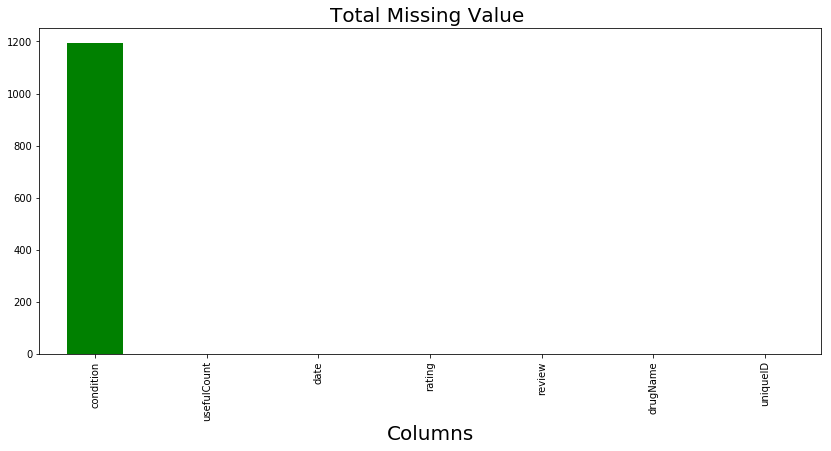

In [23]:
percent = (df_all.isnull().sum()).sort_values(ascending=False)
percent.plot(kind="bar", figsize = (14,6), fontsize = 10, color='green')
plt.xlabel("Columns", fontsize = 20)
plt.ylabel("", fontsize = 20)
plt.title("Total Missing Value ", fontsize = 20)

In [24]:
print("Missing value (%):", 1200/df_all.shape[0] *100)

Missing value (%): 0.5579760349292998


We will delete because the percentage is lower than 1%.

## 2. Date Preprocessing

### 2.1. Missing Values Removal

In [25]:
df_train = df_train.dropna(axis=0)
df_test = df_test.dropna(axis=0)

Text(0.5, 1.0, 'Total Missing Value ')

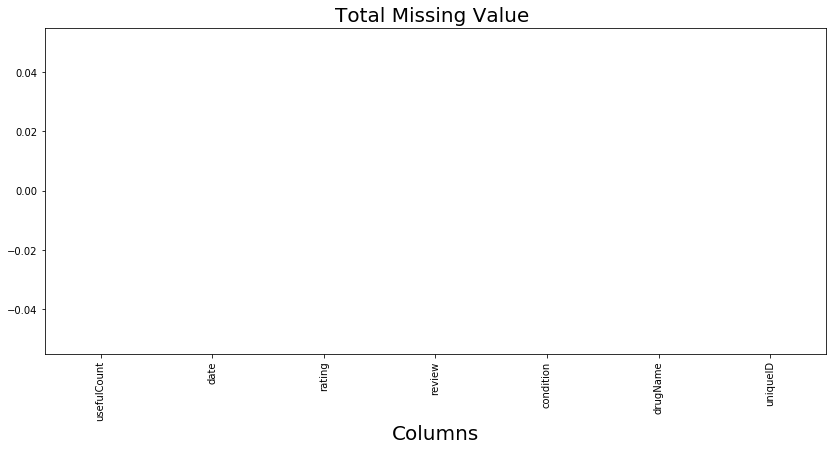

In [26]:
df_all = pd.concat([df_train,df_test]).reset_index()
del df_all['index']
percent = (df_all.isnull().sum()).sort_values(ascending=False)
percent.plot(kind="bar", figsize = (14,6), fontsize = 10, color='green')
plt.xlabel("Columns", fontsize = 20)
plt.ylabel("", fontsize = 20)
plt.title("Total Missing Value ", fontsize = 20)

### 2.2 Condition Preprocessing

We will delete the sentences with the form above.

In [27]:
all_list = set(df_all.index)
span_list = []
for i,j in enumerate(df_all['condition']):
    if '</span>' in j:
        span_list.append(i)

In [28]:
new_idx = all_list.difference(set(span_list))
df_all = df_all.iloc[list(new_idx)].reset_index()
del df_all['index']

Next, we will delete conditions with only one drug.

In [29]:
df_condition = df_all.groupby(['condition'])['drugName'].nunique().sort_values(ascending=False)
df_condition = pd.DataFrame(df_condition).reset_index()
df_condition.tail(20)

,condition,drugName
816,Hemangioma,1
817,Q Feve,1
818,Urinary Retention,1
819,Diagnostic Bronchograms,1
820,Steroid Responsive Inflammatory Conditions,1
821,Cluster-Tic Syndrome,1
822,Nausea (phosphorated carbohydrate solution),1
823,Ramsay Hunt Syndrome,1
824,Rat-bite Feve,1
825,Hemorrhoids (pramoxine / zinc oxide),1


In [30]:
df_condition_1 = df_condition[df_condition['drugName']==1].reset_index()
df_condition_1['condition'][0:10]

0                           Uveitis, Posteri
1                    Pseudogout, Prophylaxis
2                        Infectious Diarrhea
3                   Thyroid Suppression Test
4                                 Angioedema
5                                Scleroderma
6                                        mis
7            Anti NMDA Receptor Encephalitis
8                                     mist (
9    Pruritus of Partial Biliary Obstruction
Name: condition, dtype: object

In [31]:
all_list = set(df_all.index)
condition_list = []
for i,j in enumerate(df_all['condition']):
    for c in list(df_condition_1['condition']):
        if j == c:
            condition_list.append(i)
            
new_idx = all_list.difference(set(condition_list))
df_all = df_all.iloc[list(new_idx)].reset_index()
del df_all['index']

### 2.3 Review Preprocessing

- \r\n : we need to convert html grammer
- ... , &#039; : deal with not alphabet

In [33]:
stops = set(stopwords.words('english'))

In [34]:
not_stop = ["aren't","couldn't","didn't","doesn't","don't","hadn't","hasn't","haven't","isn't","mightn't","mustn't","needn't","no","nor","not","shan't","shouldn't","wasn't","weren't","wouldn't"]
for i in not_stop:
    stops.remove(i)

In [36]:
stemmer = SnowballStemmer('english')

def review_to_words(raw_review):
    # 1. Delete HTML 
    review_text = BeautifulSoup(raw_review, 'html.parser').get_text()
    # 2. Make a space
    letters_only = re.sub('[^a-zA-Z]', ' ', review_text)
    # 3. lower letters
    words = letters_only.lower().split()
    # 5. Stopwords 
    meaningful_words = [w for w in words if not w in stops]
    # 6. Stemming
    stemming_words = [stemmer.stem(w) for w in meaningful_words]
    # 7. space join words
    return( ' '.join(stemming_words))

In [37]:
%time df_all['review_clean'] = df_all['review'].apply(review_to_words)

CPU times: user 2min 41s, sys: 298 ms, total: 2min 42s
Wall time: 2min 42s


## 3. Predictive Model

### 3.1. Deep Learning Model Using N-gram

In [ ]:
# Make a rating
df_all['sentiment'] = df_all["rating"].apply(lambda x: 1 if x > 5 else 0)

In [ ]:
df_train, df_test = train_test_split(df_all, test_size=0.33, random_state=42) 

In [ ]:
df_train

In [ ]:
vectorizer = CountVectorizer(analyzer = 'word', 
                             tokenizer = None,
                             preprocessor = None, 
                             stop_words = None, 
                             min_df = 2, 
                             ngram_range=(4, 4),
                             max_features = 20000
                            )
vectorizer

In [ ]:

pipeline = Pipeline([
    ('vect', vectorizer),
])

In [ ]:
%time train_data_features = pipeline.fit_transform(df_train['review_clean'])
%time test_data_features = pipeline.fit_transform(df_test['review_clean'])


In [ ]:
all_features=pipeline.fit_transform(df_all['review_clean'])

In [ ]:
# 1. Dataset
y_train = df_train['sentiment']
y_test = df_test['sentiment']
solution = y_test.copy()

# 2. Model Structure
model = keras.models.Sequential()

model.add(keras.layers.Dense(200, input_shape=(20000,)))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Activation('relu'))
model.add(keras.layers.Dropout(0.5))

model.add(keras.layers.Dense(300))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Activation('relu'))
model.add(keras.layers.Dropout(0.5))

model.add(keras.layers.Dense(100, activation='relu'))
model.add(keras.layers.Dense(1, activation='sigmoid'))

# 3. Model compile
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
model.summary()

In [ ]:
train_data_features

In [ ]:
y_train

In [ ]:
# 4. Train model
hist = model.fit(train_data_features, y_train, epochs=10, batch_size=64)

# 5. Traing process
%matplotlib inline
import matplotlib.pyplot as plt

fig, loss_ax = plt.subplots()

acc_ax = loss_ax.twinx()

loss_ax.set_ylim([0.0, 1.0])
acc_ax.set_ylim([0.0, 1.0])

loss_ax.plot(hist.history['loss'], 'y', label='train loss')
acc_ax.plot(hist.history['acc'], 'b', label='train acc')

loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
acc_ax.set_ylabel('accuray')

loss_ax.legend(loc='upper left')
acc_ax.legend(loc='lower left')

plt.show()

In [ ]:
# 6. Evaluation
loss_and_metrics = model.evaluate(test_data_features, y_test, batch_size=32)
print('loss_and_metrics : ' + str(loss_and_metrics))

In [ ]:
sub_preds_deep = model.predict(all_features,batch_size=32)

In [ ]:
df_all['deep_pred'] = sub_preds_deep

In [ ]:
df_all.to_csv('final.csv')

In [ ]:
df_all = df_all.groupby(['condition','drugName']).agg({'deep_pred' : ['mean']})
df_all

In [ ]:
if df_test['condition'] == df['condition']:
     

In [ ]:
import pandas as pd
df_all_r = pd.read_csv('final.csv')

In [ ]:
df_all_r

In [ ]:
df_all_r = df_all_r.groupby(['Unnamed: 0','Unnamed: 1']).agg({'deep_pred' : ['mean']})

## 4. Result

Our team set the topic as recommending the right medicine for the patient's condition with reviews and proceeded the project according to the topic with the data exploration, data preprocessing and modeling. In the data exploration section, we looked at the forms of data using visualization techniques and statistical techniques. The next step was to preprocess the data according to the topic we set, such as removing the condition that has only one drug for recommendation. In the process of modeling, we used deep learning model with n-gram.These steps allowed us to calculate the final predicted value and recommend the appropriate drug for each condition according to the order of the value.

In [1]:
df_all_r = pd.read_csv('final.csv')

In [2]:
df_all_r

,Unnamed: 0,Unnamed: 1,deep_pred
0,NaN,NaN,mean
1,condition,drugName,NaN
2,ADHD,Adderall,0.6800304
3,ADHD,Adderall XR,0.69680107
4,ADHD,Adzenys XR-ODT,0.591997
5,ADHD,Amantadine,0.78281283
6,ADHD,Amphetamine,0.6323861
7,ADHD,Amphetamine / dextroamphetamine,0.689662
8,ADHD,Aptensio XR,0.8589785
9,ADHD,Armodafinil,0.6475846


In [3]:
df = df_all_r.iloc[2:]

In [4]:
df.head()

,Unnamed: 0,Unnamed: 1,deep_pred
2,ADHD,Adderall,0.6800304
3,ADHD,Adderall XR,0.69680107
4,ADHD,Adzenys XR-ODT,0.591997
5,ADHD,Amantadine,0.78281283
6,ADHD,Amphetamine,0.6323861


In [5]:
df.columns = ['condition','drugName','deep_pred']

In [6]:
df.columns

Index(['condition', 'drugName', 'deep_pred'], dtype='object')

In [7]:
df.dtypes

condition    object
drugName     object
deep_pred    object
dtype: object

In [8]:
df['deep_pred'] = df['deep_pred'].astype(str).astype(float)

/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [9]:
df.dtypes

condition     object
drugName      object
deep_pred    float64
dtype: object

In [10]:
df

,condition,drugName,deep_pred
2,ADHD,Adderall,0.680030
3,ADHD,Adderall XR,0.696801
4,ADHD,Adzenys XR-ODT,0.591997
5,ADHD,Amantadine,0.782813
6,ADHD,Amphetamine,0.632386
7,ADHD,Amphetamine / dextroamphetamine,0.689662
8,ADHD,Aptensio XR,0.858978
9,ADHD,Armodafinil,0.647585
10,ADHD,Atomoxetine,0.690662
11,ADHD,Budeprion XL,0.676246


In [11]:
df_all = df.groupby(['condition','drugName']).agg({'deep_pred' : ['mean']})

In [12]:
df = df.reset_index(drop=True)

In [13]:
df.head()

,condition,drugName,deep_pred
0,ADHD,Adderall,0.680030
1,ADHD,Adderall XR,0.696801
2,ADHD,Adzenys XR-ODT,0.591997
3,ADHD,Amantadine,0.782813
4,ADHD,Amphetamine,0.632386


In [14]:
df.to_csv('recommendation_engine.csv')

In [15]:
user_input = pd.DataFrame(df.iloc[10])

In [16]:
user_input = user_input.T.reset_index(drop=True)

In [17]:
user_input

,condition,drugName,deep_pred
0,ADHD,Bupropion,0.698472


In [22]:
recommended_drugs = []

In [19]:
temp = [1,2]

In [23]:
for i in range(len(df)):
    if df['condition'][i] == user_input['condition'][0] and df['deep_pred'][i] >= user_input['deep_pred'][0] :
        temp = [df["drugName"][i],df['deep_pred'][i]]
        recommended_drugs.append(temp)

In [24]:
recommended_drugs

[['Amantadine', 0.78281283],
 ['Aptensio XR', 0.8589785],
 ['Bupropion', 0.69847214],
 ['Catapres', 0.84745115],
 ['Clonidine', 0.7787613],
 ['Cylert', 0.76087755],
 ['Desvenlafaxine', 0.954976],
 ['Guanfacine', 0.7287347],
 ['Intuniv', 0.724747],
 ['Kapvay', 0.76216817],
 ['Metadate CD', 0.7483774],
 ['Mydayis', 0.7434753],
 ['Pemoline', 0.76087755],
 ['Pristiq', 0.95084476],
 ['Ritalin LA', 0.7227036]]

## 5. Limitations

In conclusion, these are the limitations we had during the project.

1. Sentiment analysis using sentiment word dictionary has low reliability when the number of positive and negative words is small. For example, if there are 0 positive words and 1 negative word, it is classified as negative. Therefore, if the number of sentiment words is 5 or less, we could exclude the observations.
2. To ensure the reliability of the predicted values, we normalized usefulCount and multiplied it to the predicted values. However, usefulCount may tend to be higher for older reviews as the number of cumulated site visitors increases. Therefore, we should have also considered time when normalizing usefulCount.




## END